In [1]:
import os
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from scipy.stats import zscore

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
__SEED__ = 12345
np.random.seed(__SEED__)

# Parameters
n_samples = 10000
true_p = 0.25  # Probability for binary variable
rho_bc = -0.35
rho_ab = -0.2
true_mean_b = 2
true_std_b = 0.5
true_mean_c = 3
true_std_c = 1

# Generate independent data
true_a = np.random.binomial(1, true_p, size=n_samples)  # Binary values
true_b = np.random.normal(true_mean_b, true_std_b, size=n_samples)       # Continuous values
true_c = np.random.normal(true_mean_c, true_std_c, size=n_samples)       # Continuous values

# Standardize true_b and true_c for correlation
b_standard = zscore(true_b)
c_standard = zscore(true_c)

# Correlation matrix for b and c
corr_matrix_bc = np.array([[1, rho_bc], [rho_bc, 1]])
L_bc = np.linalg.cholesky(corr_matrix_bc)

# Apply correlation to b and c
bc_correlated = L_bc @ np.vstack([b_standard, c_standard])
true_b, true_c = bc_correlated

# Rescale b and c to match original means and stds
true_b = true_b * true_std_b + true_mean_b  # std = 0.5, mean = 2
true_c = true_c * true_std_c + true_mean_c  # std = 1.0, mean = 3

# Compute observed variable
true_y = true_a * true_b * true_c

# Summary statistics
mean_a, mean_b, mean_c, mean_y = true_a.mean(), true_b.mean(), true_c.mean(), true_y.mean()
std_a, std_b, std_c, std_y = true_a.std(), true_b.std(), true_c.std(), true_y.std()

print("Means:", mean_a, mean_b, mean_c, mean_y, sep="\n")
print("Stds:", std_a, std_b, std_c, std_y, sep='\n')


Means:
0.256
1.9999999999999996
2.9999999999999996
1.4897917899849098
Stds:
0.4364218143035474
0.5
1.002721378681202
2.750472910180699


In [3]:
# Check for correlations in the synthetic data
synthetic_data = pd.DataFrame({"a": true_a, "b": true_b, "c": true_c})
correlations = synthetic_data.corr()
print(correlations)

          a         b         c
a  1.000000  0.006116 -0.002355
b  0.006116  1.000000 -0.356815
c -0.002355 -0.356815  1.000000


In [4]:
# approx E[y] = E[a] * E[b] * E[c]
approx_true_y = np.mean(true_a) * np.mean(true_b) * np.mean(true_c)
approx_true_y, mean_y, approx_true_y - mean_y

(1.5359999999999994, 1.4897917899849098, 0.04620821001508957)

In [5]:
# prior ctes for the parameters of the variables distributions
a_alpha0 = 1
a_beta0 = 1 

b_mu0 = 0
b_sigma0 = 10

c_mu0 = 0
c_sigma0 = 10

# eta : float
#     Parameter for the LKJ correlation prior (controls 'strength' of correlation prior)
eta_bc = 1

y_mu0 = 0
y_sigma0 = 10

In [6]:
# Low-dimensional Bayesian model
model = pm.Model()
with model:
    # Priors for the means
    p_a = pm.Beta("p_a", alpha=a_alpha0, beta=a_beta0)  # Prior for binary probability
    a = pm.Bernoulli("obs_a", p=p_a, shape=n_samples, observed=true_a)  # Binary values

    # 1) Priors for means of b and c
    mu_b = pm.Normal("mu_b", mu=b_mu0, sigma=b_sigma0)
    mu_c = pm.Normal("mu_c", mu=c_mu0, sigma=c_sigma0)
    
    # Combine into a vector for convenience
    mu_bc = pm.math.stack([mu_b, mu_c])

    # 2) Prior over covariance using LKJCholeskyCov
        #    - 'eta' controls how strongly we believe in correlation being near 0 or not
        #    - 'sd_dist' is the prior for standard deviations
    chol_bc, corr_bc, stds_bc = pm.LKJCholeskyCov(
        "chol_cov",
        n=2,             # dimension = 2 for (b, c)
        eta=eta_bc,         # LKJ shape parameter
        sd_dist=pm.Exponential.dist(1.0),  # prior for std devs
        compute_corr=True  # also track the correlation matrix
    )
    
    cov_bc = pm.Deterministic("cov_bc", chol_bc @ chol_bc.T)
        
    # 3) Likelihood: bivariate normal with mean = mu and covariance = cov
    #    Instead of cov, we pass 'chol=chol' for numerical stability
    obs_bc = pm.MvNormal("obs_bc", mu=mu_bc, chol=chol_bc, observed=np.column_stack([true_b, true_c]))
    
    mu_y = pm.Normal("mu_y", mu=y_mu0, sigma=y_sigma0)
    sigma_y = pm.HalfNormal("sigma_y", sigma=std_y)
    y = pm.Normal("obs_y", mu=mu_y, sigma=sigma_y / np.sqrt(n_samples), observed=true_y)

model

          p_a ~ Beta(1, 1)
         mu_b ~ Normal(0, 10)
         mu_c ~ Normal(0, 10)
     chol_cov ~ _lkjcholeskycov(2, 1, Exponential(f()))
         mu_y ~ Normal(0, 10)
      sigma_y ~ HalfNormal(0, 2.75)
chol_cov_corr ~ Deterministic(f(chol_cov))
chol_cov_stds ~ Deterministic(f(chol_cov))
       cov_bc ~ Deterministic(f(chol_cov))
        obs_a ~ Bernoulli(p_a)
       obs_bc ~ MultivariateNormal(f(mu_c, mu_b, chol_cov), f(chol_cov))
        obs_y ~ Normal(mu_y, f(sigma_y))

In [7]:
model.named_vars

{'p_a': p_a ~ Beta(1, 1),
 'obs_a': obs_a ~ Bernoulli(p_a),
 'mu_b': mu_b ~ Normal(0, 10),
 'mu_c': mu_c ~ Normal(0, 10),
 'chol_cov': chol_cov ~ _lkjcholeskycov(2, 1, Exponential(f())),
 'chol_cov_corr': chol_cov_corr ~ Deterministic(f(chol_cov)),
 'chol_cov_stds': chol_cov_stds ~ Deterministic(f(chol_cov)),
 'cov_bc': cov_bc ~ Deterministic(f(chol_cov)),
 'obs_bc': obs_bc ~ MultivariateNormal(f(mu_c, mu_b, chol_cov), f(chol_cov)),
 'mu_y': mu_y ~ Normal(0, 10),
 'sigma_y': sigma_y ~ HalfNormal(0, 2.75),
 'obs_y': obs_y ~ Normal(mu_y, f(sigma_y))}

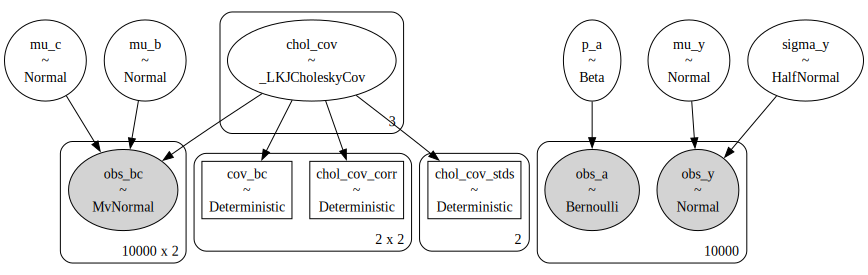

In [8]:
# requires brew/choco install graphviz in your local machine and add python package to pyproject.toml as well
pm.model_to_graphviz(model)

In [9]:
n_draws_per_chain = 1000
n_tune = 1000
n_chains = 4
n_cores = 4

with model:
    # Sample from the posterior
    trace = pm.sample(
        draws=n_draws_per_chain,
        tune=n_tune,
        chains=n_chains,
        cores=n_cores,
        random_seed=__SEED__,
        progressbar=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_a, mu_b, mu_c, chol_cov, mu_y, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


In [10]:
# Summarize results
summary = az.summary(trace, var_names=["p_a", "mu_b", "mu_c", "cov_bc", "chol_cov_corr", "mu_y"], hdi_prob=0.95)
print(summary)

                      mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
p_a                  0.256  0.004     0.248      0.264        0.0      0.0   
mu_b                 2.000  0.005     1.990      2.010        0.0      0.0   
mu_c                 3.000  0.010     2.980      3.020        0.0      0.0   
cov_bc[0, 0]         0.250  0.004     0.243      0.257        0.0      0.0   
cov_bc[0, 1]        -0.179  0.005    -0.189     -0.169        0.0      0.0   
cov_bc[1, 0]        -0.179  0.005    -0.189     -0.169        0.0      0.0   
cov_bc[1, 1]         1.006  0.014     0.980      1.033        0.0      0.0   
chol_cov_corr[0, 0]  1.000  0.000     1.000      1.000        0.0      0.0   
chol_cov_corr[0, 1] -0.357  0.009    -0.374     -0.340        0.0      0.0   
chol_cov_corr[1, 0] -0.357  0.009    -0.374     -0.340        0.0      0.0   
chol_cov_corr[1, 1]  1.000  0.000     1.000      1.000        0.0      0.0   
mu_y                 1.490  0.022     1.446      1.531        0.

d:\Dropbox\github\fontanads\statsdojo\.venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


array([[<Axes: title={'center': 'p_a'}>, <Axes: title={'center': 'p_a'}>],
       [<Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'mu_c'}>,
        <Axes: title={'center': 'mu_c'}>],
       [<Axes: title={'center': 'cov_bc'}>,
        <Axes: title={'center': 'cov_bc'}>],
       [<Axes: title={'center': 'mu_y'}>,
        <Axes: title={'center': 'mu_y'}>]], dtype=object)

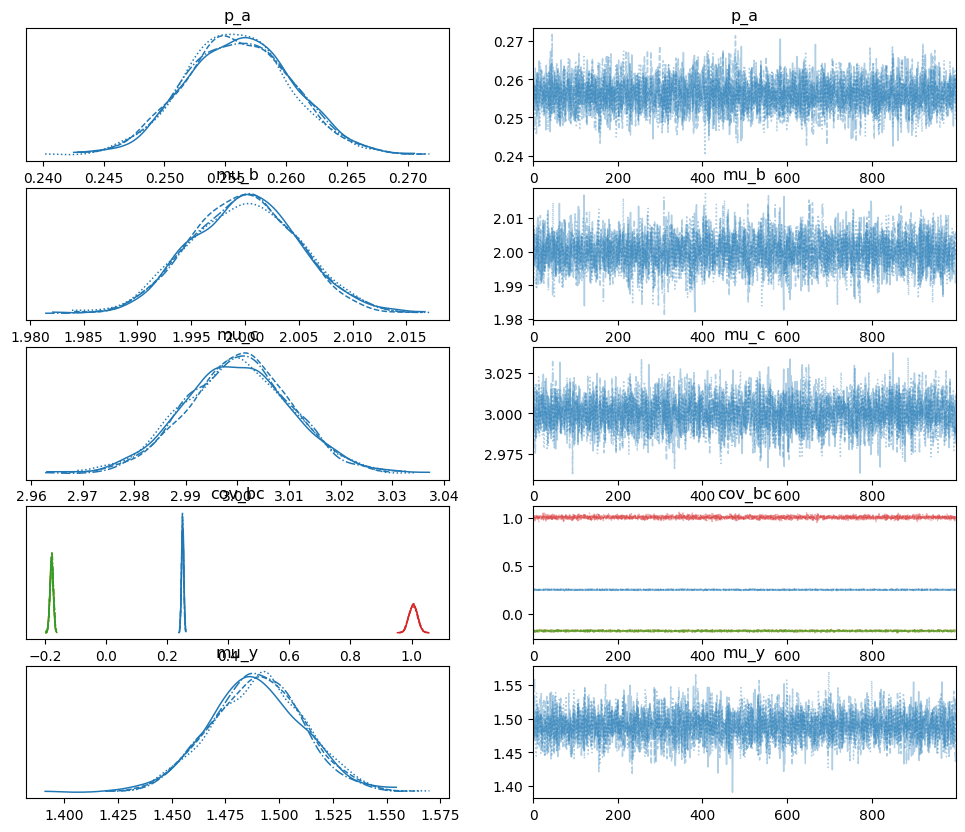

In [11]:
# Plot results
az.plot_trace(trace, var_names=["p_a", "mu_b", "mu_c", "cov_bc", "mu_y"])

array([[<Axes: title={'center': 'p_a'}>,
        <Axes: title={'center': 'mu_b'}>,
        <Axes: title={'center': 'mu_c'}>,
        <Axes: title={'center': 'cov_bc\n0, 0'}>],
       [<Axes: title={'center': 'cov_bc\n0, 1'}>,
        <Axes: title={'center': 'cov_bc\n1, 0'}>,
        <Axes: title={'center': 'cov_bc\n1, 1'}>,
        <Axes: title={'center': 'mu_y'}>]], dtype=object)

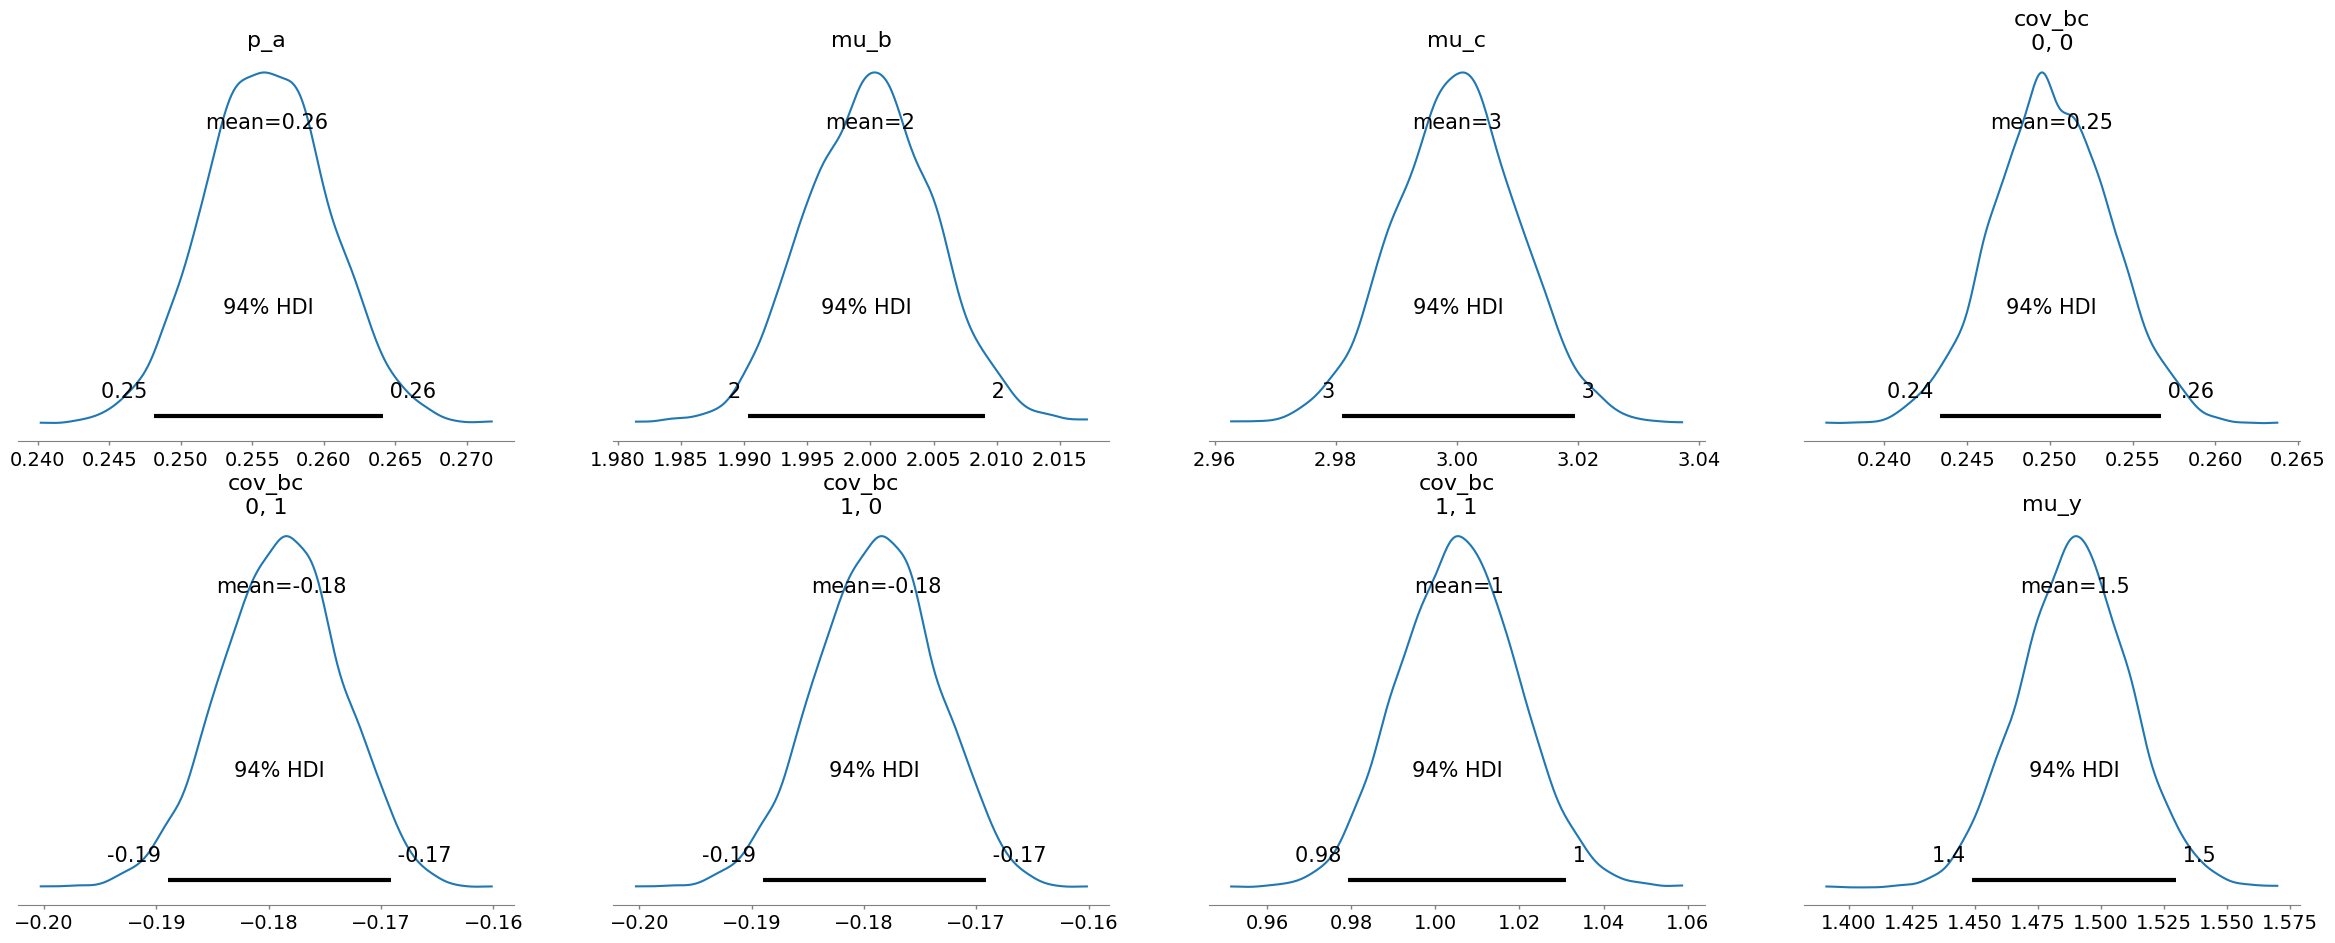

In [12]:
# plot posterior
az.plot_posterior(trace, var_names=["p_a", "mu_b", "mu_c", "cov_bc", "mu_y"])

In [13]:
with model:
    idata = pm.sample(100, tune=2000, random_seed=42)
    
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_a, mu_b, mu_c, chol_cov, mu_y, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 100 draw iterations (8_000 + 400 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [14]:
idata.posterior['mu_y'].shape, idata.posterior['mu_y'].values

((4, 100),
 array([[1.49818742, 1.50992674, 1.4688183 , 1.53764192, 1.50821408,
         1.5021346 , 1.47946255, 1.49354135, 1.49829979, 1.4846218 ,
         1.49508694, 1.45710069, 1.52814948, 1.45022251, 1.47638114,
         1.45273565, 1.51210087, 1.49621823, 1.50296579, 1.48077422,
         1.49116078, 1.4907182 , 1.49079204, 1.46317796, 1.46610042,
         1.51212797, 1.48122348, 1.49549518, 1.46871835, 1.50728975,
         1.50728975, 1.53068252, 1.47199579, 1.49750153, 1.47467592,
         1.5144989 , 1.47134222, 1.52034138, 1.48411459, 1.50294511,
         1.48197456, 1.48314581, 1.50821818, 1.46792831, 1.48926092,
         1.4534632 , 1.43595382, 1.5204348 , 1.47201681, 1.47060689,
         1.45679013, 1.5069725 , 1.47791654, 1.50045595, 1.49820867,
         1.47092484, 1.50707741, 1.46297721, 1.46640854, 1.51098372,
         1.45817041, 1.4852359 , 1.48530138, 1.45769038, 1.45769038,
         1.48991823, 1.49582784, 1.47482034, 1.48437092, 1.48473204,
         1.47071929, 1.

In [15]:
idata.posterior['mu_y'].mean(dim=['chain', 'draw']), idata.posterior['mu_y'].mean(dim=['chain']), idata.posterior['mu_y'].mean(dim=['draw'])

(<xarray.DataArray 'mu_y' ()> Size: 8B
 array(1.48895417),
 <xarray.DataArray 'mu_y' (draw: 100)> Size: 800B
 array([1.5029558 , 1.48793988, 1.46315864, 1.51535697, 1.49183956,
        1.50830536, 1.49700299, 1.48559048, 1.47327092, 1.49357585,
        1.49954667, 1.47111197, 1.50544539, 1.499447  , 1.49491367,
        1.47760573, 1.48470071, 1.50401761, 1.494309  , 1.49474107,
        1.47704825, 1.48719285, 1.49871546, 1.47764849, 1.47427166,
        1.50818421, 1.47766541, 1.49076259, 1.48710993, 1.48816976,
        1.49623926, 1.50651068, 1.49601752, 1.50230883, 1.46976048,
        1.49759371, 1.50375389, 1.48064566, 1.48318263, 1.49715965,
        1.481803  , 1.49131325, 1.48711725, 1.47386846, 1.48409062,
        1.47838405, 1.48578575, 1.50854143, 1.4806934 , 1.48334231,
        1.47501404, 1.5058597 , 1.48856515, 1.50101933, 1.4821073 ,
        1.49467381, 1.48785737, 1.47322277, 1.48869597, 1.49203371,
        1.47665149, 1.48828306, 1.49819075, 1.49522013, 1.45587461,
       

(array([[<Axes: title={'center': 'mu_y'}>,
         <Axes: title={'center': 'mu_y'}>]], dtype=object),
 array([[<Axes: title={'center': 'mu_y'}>,
         <Axes: title={'center': 'mu_y'}>]], dtype=object))

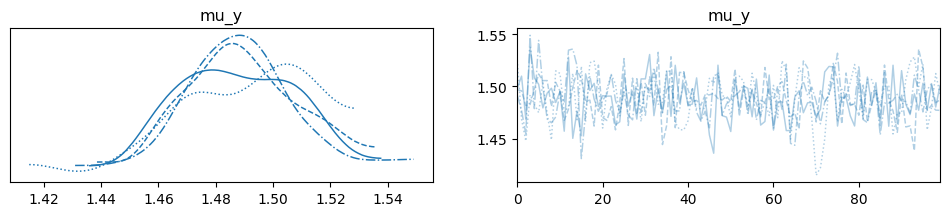

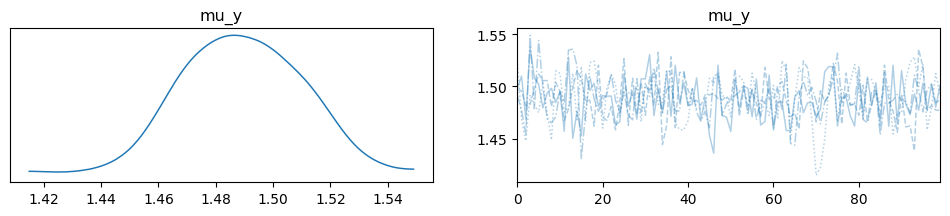

In [16]:
az.plot_trace(idata.posterior['mu_y']), az.plot_trace(idata.posterior['mu_y'], combined=True)

In [17]:
idata.posterior['mu_y']

<xarray.DataArray 'mu_y' (chain: 4, draw: 100)> Size: 3kB
array([[1.49818742, 1.50992674, 1.4688183 , 1.53764192, 1.50821408,
        1.5021346 , 1.47946255, 1.49354135, 1.49829979, 1.4846218 ,
        1.49508694, 1.45710069, 1.52814948, 1.45022251, 1.47638114,
        1.45273565, 1.51210087, 1.49621823, 1.50296579, 1.48077422,
        1.49116078, 1.4907182 , 1.49079204, 1.46317796, 1.46610042,
        1.51212797, 1.48122348, 1.49549518, 1.46871835, 1.50728975,
        1.50728975, 1.53068252, 1.47199579, 1.49750153, 1.47467592,
        1.5144989 , 1.47134222, 1.52034138, 1.48411459, 1.50294511,
        1.48197456, 1.48314581, 1.50821818, 1.46792831, 1.48926092,
        1.4534632 , 1.43595382, 1.5204348 , 1.47201681, 1.47060689,
        1.45679013, 1.5069725 , 1.47791654, 1.50045595, 1.49820867,
        1.47092484, 1.50707741, 1.46297721, 1.46640854, 1.51098372,
        1.45817041, 1.4852359 , 1.48530138, 1.45769038, 1.45769038,
        1.48991823, 1.49582784, 1.47482034, 1.48437092, 1.48473204,
        1.47071929, 1.47811135, 1.51400373, 1.51920955, 1.51881775,
        1.46203942, 1.4894794 , 1.4894794 , 1.47170659, 1.46209828,
        1.50786455, 1.47312347, 1.5090365 , 1.48175264, 1.50357006,
        1.46235333, 1.5133563 , 1.46185091, 1.52038783, 1.46447416,
        1.51517083, 1.48290775, 1.47301813, 1.49287435, 1.47724945,
        1.50307496, 1.47767922, 1.50148571, 1.48029756, 1.50080459],
...
       [1.49155294, 1.47715654, 1.45440568, 1.54911991, 1.47874699,
        1.54425526, 1.49946792, 1.46877843, 1.46520062, 1.47068762,
        1.49502656, 1.48444628, 1.53484397, 1.53595344, 1.51975535,
        1.43080054, 1.47463949, 1.51016946, 1.48795194, 1.47621247,
        1.48663783, 1.49278818, 1.51189255, 1.48674069, 1.47497756,
        1.49492267, 1.47257847, 1.46800875, 1.50746816, 1.47531591,
        1.50129805, 1.49571301, 1.51802628, 1.49605346, 1.47507498,
        1.49719096, 1.50126712, 1.47649663, 1.47649663, 1.51418358,
        1.48127204, 1.49786585, 1.47521065, 1.46666679, 1.47628548,
        1.46030235, 1.51057788, 1.51142923, 1.47226461, 1.48326721,
        1.48664571, 1.4913136 , 1.49496312, 1.5017006 , 1.47259266,
        1.49885256, 1.46786509, 1.48664665, 1.48465059, 1.4976436 ,
        1.45958718, 1.49759759, 1.47801395, 1.52136861, 1.44537597,
        1.44354683, 1.49167038, 1.50503269, 1.49146955, 1.49922   ,
        1.48574089, 1.46413632, 1.48500466, 1.49203832, 1.50794346,
        1.53191767, 1.48338934, 1.49313679, 1.48174446, 1.48350636,
        1.51988025, 1.4683039 , 1.46525604, 1.49563653, 1.49563653,
        1.45354518, 1.48399897, 1.48399897, 1.4867749 , 1.4924814 ,
        1.48624953, 1.48557375, 1.47428241, 1.51093728, 1.49660949,
        1.47561032, 1.4967035 , 1.50274364, 1.48450102, 1.48714548]])
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 400B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99

In [18]:
# this is just a copy of the observed data that is carried around with the InferenceData object
print(idata.observed_data['obs_y'])
np.allclose(idata.observed_data['obs_y'].values, true_y)

<xarray.DataArray 'obs_y' (obs_y_dim_0: 10000)> Size: 80kB
array([4.315637 , 0.       , 0.       , ..., 0.       , 0.       ,
       5.2096918])
Coordinates:
  * obs_y_dim_0  (obs_y_dim_0) int32 40kB 0 1 2 3 4 ... 9995 9996 9997 9998 9999


True